<div style="text-align: center;">

# **Multivariate Regression**

</div>

# **Packages**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invgamma, norm

In [2]:
np.random.seed(42)

# **Model Specification**

Assume we are considering the following model:

$$
\mathbf{Y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}
$$

Where:

- $\mathbf{Y}$ is the $N \times 1$ response vector
- $\mathbf{X}$ is the $N \times P$ design matrix (each row represents one observation)
- $\boldsymbol{\beta}$ is the $P \times 1$ vector of regression coefficients
- $\boldsymbol{\epsilon}$ is the $N \times 1$ vector of errors

The error term is distributed as:

$$
\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^2\mathbf{I}_N)
$$

Where:

- $\mathbf{0}$ is an $N \times 1$ vector of zeros
- $\mathbf{I}_N$ is the $N \times N$ identity matrix
- $\sigma^2$ is the common variance parameter

# **Visualise Simulated Data**

In [ ]:
# parameter values
N = 100 # n observations
P = 3    # n of predictors
true_beta = np.array([1.5, -2.0, 0.5])  # true coefficients
true_sigma = 0.5
true_sigma_sq = true_sigma**2

# generate simulated data
X = np.random.randn(N, P)  # design matrix with N observations and P predictors
epsilon = np.random.randn(N) * true_sigma  # errors
y = X @ true_beta + epsilon  # response variable

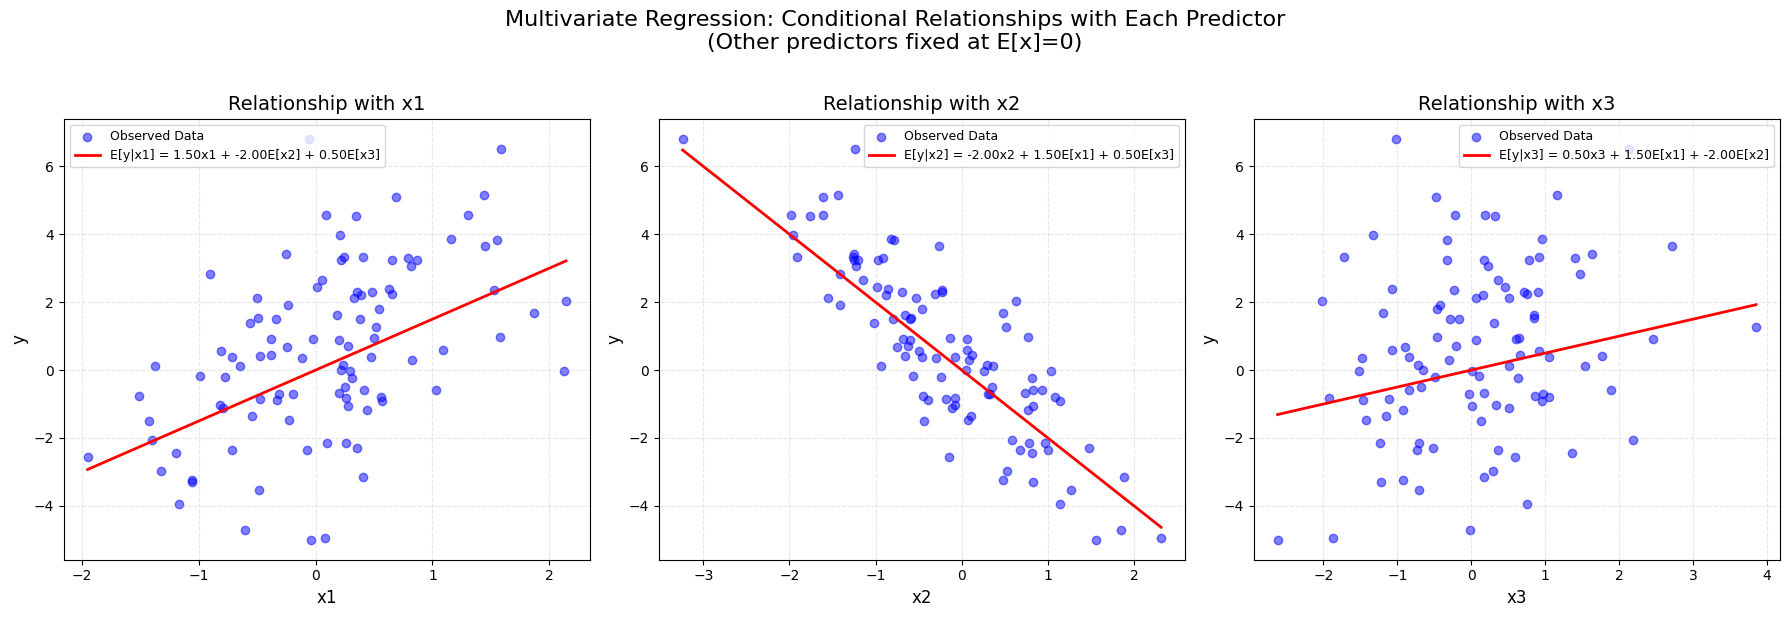

In [ ]:
# Create a figure with 3 subplots (one for each predictor)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each predictor
for i in range(P):
    ax = axes[i]
    
    # Plot raw data points for this predictor
    ax.scatter(X[:, i], y, alpha=0.5, label='Observed Data', color='blue')
    
    # Create prediction matrix where we vary only the current predictor
    x_line = np.linspace(min(X[:, i]), max(X[:, i]), 100)
    X_line = np.zeros((100, P))
    X_line[:, i] = x_line  # vary only the i-th predictor
    
    # Calculate conditional expectation (other predictors set to 0)
    y_line = X_line @ true_beta
    
    # Plot true conditional relationship
    ax.plot(x_line, y_line, 'r-', linewidth=2,
            label=f'E[y|x{i+1}] = {true_beta[i]:.2f}x{i+1} + ' + 
                  ' + '.join([f'{true_beta[j]:.2f}E[x{j+1}]' for j in range(P) if j != i]))
    
    # Customize subplot
    ax.set_title(f'Relationship with x{i+1}', fontsize=14)
    ax.set_xlabel(f'x{i+1}', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(fontsize=9, loc='upper left' if i == 0 else 'best')

plt.suptitle('Multivariate Regression: Conditional Relationships with Each Predictor\n(Other predictors fixed at E[x]=0)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# **Conditional Distribution**

For each observation $i$:

$$
y_i | \boldsymbol{\beta}, \sigma^2 \sim \mathcal{N}(\mathbf{x}_i\boldsymbol{\beta}, \sigma^2)
$$

Where:

- $y_i$ is the scalar response for observation $i$
- $\mathbf{x}_i$ is the $1 \times P$ row vector of predictors for observation $i$
- $\boldsymbol{\beta}$ is the $P \times 1$ column vector of coefficients
- $\sigma^2$ is the scalar variance parameter

Given $\mathbf{X}$, $\boldsymbol{\beta}$, and $\sigma^2$, the likelihood of $\mathbf{Y}$ is:

$$
p(\mathbf{Y} | \mathbf{X}, \boldsymbol{\beta}, \sigma^2) = (2\pi\sigma^2)^{-N/2} \exp\left(-\frac{1}{2\sigma^2}(\mathbf{Y} - \mathbf{X}\boldsymbol{\beta})^\top(\mathbf{Y} - \mathbf{X}\boldsymbol{\beta})\right)
$$

# **Prior Distributions**

We assume the following prior for $\boldsymbol{\beta}$ given $\sigma^2$ (multivariate normal):

$$
p(\boldsymbol{\beta} | \sigma^2) = (2\pi\sigma^2)^{-P/2} |\mathbf{A}_0|^{1/2} \exp\left(-\frac{1}{2\sigma^2}(\boldsymbol{\beta} - \boldsymbol{\mu}_0)^\top \mathbf{A}_0 (\boldsymbol{\beta} - \boldsymbol{\mu}_0)\right)
$$

Parameters:

- $\boldsymbol{\mu}_0$: $P \times 1$ prior mean vector
- $\mathbf{A}_0$: $P \times P$ prior precision matrix
- $\sigma^2$: Scales the covariance matrix ($\sigma^2 \mathbf{A}_0^{-1}$)

We assume the following prior for $\sigma^2$ (Inverse Gamma):

$$
p(\sigma^2) = \frac{b_0^{a_0}}{\Gamma(a_0)} (\sigma^2)^{-(a_0 + 1)} \exp\left(-\frac{b_0}{\sigma^2}\right)
$$

Parameters:

- $a_0 > 0$: Shape parameter
- $b_0 > 0$: Scale parameter

In [10]:
# Prior parameters (multivariate normal for beta)
P = 3  # number of predictors
mu_0 = np.zeros(P)  # prior mean vector
A_0 = np.eye(P)  # prior precision matrix (identity)

# Prior parameters (inverse gamma for sigma^2)
a_0 = 2.5  # shape parameter
b_0 = 1.5  # scale parameter

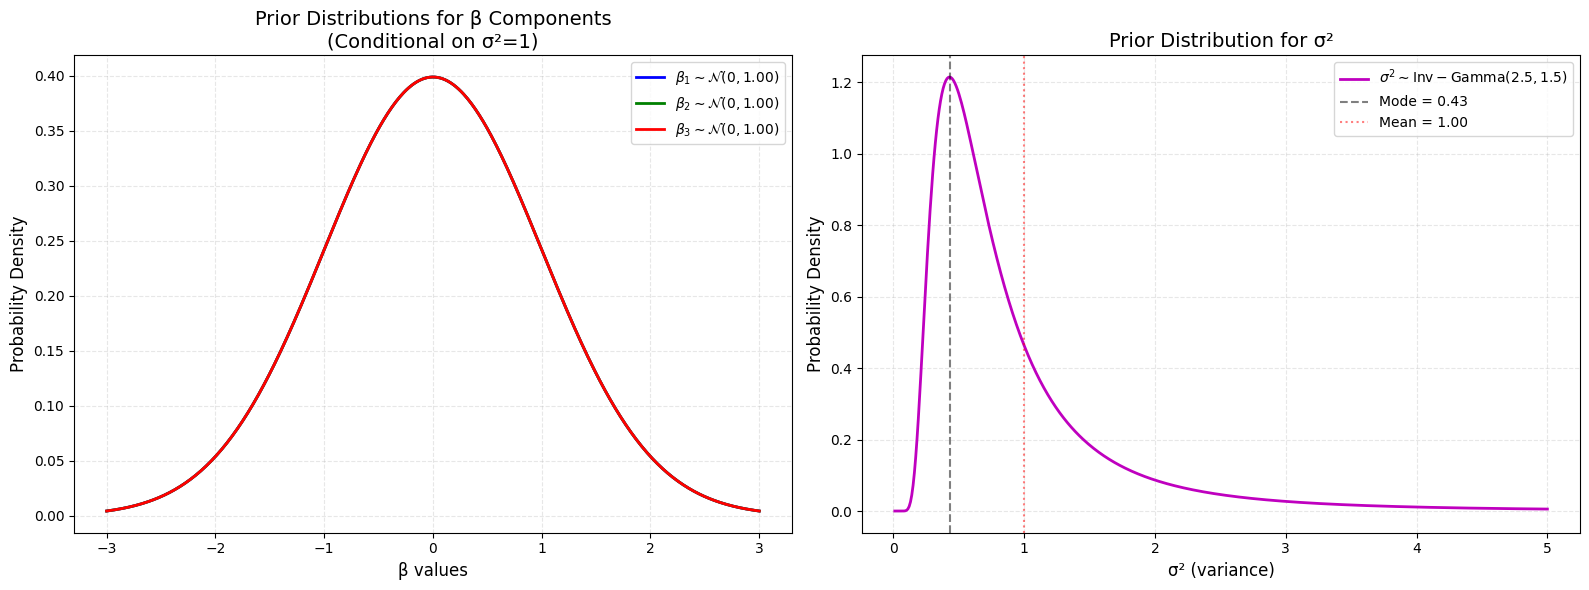

In [12]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# =============================================
# Plot 1: Prior for beta (multivariate normal)
# =============================================

# We'll show marginal distributions for each beta_p
beta_grid = np.linspace(-3, 3, 500)
colors = ['blue', 'green', 'red']

for p in range(P):
    # Marginal distribution for beta_p ~ N(mu_0[p], sigma^2 * (A_0^{-1}[p,p]))
    # Here we assume sigma^2 = 1 for visualization (since it's conditional)
    marginal_std = np.sqrt(np.linalg.inv(A_0)[p,p])  # sqrt of diagonal element
    prior_density = norm.pdf(beta_grid, loc=mu_0[p], scale=marginal_std)
    
    ax1.plot(beta_grid, prior_density, '-', linewidth=2, color=colors[p],
             label=rf'$\beta_{p+1} \sim \mathcal{{N}}(0, {marginal_std**2:.2f})$')

# Customize beta prior plot
ax1.set_title('Prior Distributions for β Components\n(Conditional on σ²=1)', fontsize=14)
ax1.set_xlabel('β values', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.3)

# =============================================
# Plot 2: Prior for sigma^2 (inverse gamma)
# =============================================

# Create grid of sigma^2 values
sigma_sq_grid = np.linspace(0.01, 5, 500)
prior_sigma_sq = invgamma.pdf(sigma_sq_grid, a=a_0, scale=b_0)

ax2.plot(sigma_sq_grid, prior_sigma_sq, 'm-', linewidth=2,
         label=rf'$\sigma^2 \sim \mathrm{{Inv-Gamma}}({a_0}, {b_0})$')

# Highlight mode (a_0 > 1) and mean
if a_0 > 1:
    mode = b_0 / (a_0 + 1)
    ax2.axvline(mode, color='k', linestyle='--', alpha=0.5,
                label=f'Mode = {mode:.2f}')
mean = b_0 / (a_0 - 1) if a_0 > 1 else np.inf
ax2.axvline(mean, color='r', linestyle=':', alpha=0.5,
            label=f'Mean = {mean:.2f}' if np.isfinite(mean) else 'Mean = ∞')

# Customize sigma^2 prior plot
ax2.set_title('Prior Distribution for σ²', fontsize=14)
ax2.set_xlabel('σ² (variance)', fontsize=12)
ax2.set_ylabel('Probability Density', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# **Joint Posterior Distribution**

The joint posterior distribution is proportional to:

$$
p(\boldsymbol{\beta}, \sigma^2 | \mathbf{Y}, \mathbf{X}) \propto p(\mathbf{Y} | \mathbf{X}, \boldsymbol{\beta}, \sigma^2) \cdot p(\boldsymbol{\beta} | \sigma^2) \cdot p(\sigma^2)
$$

It can be shown that the conditional posterior for $\boldsymbol{\beta}$ is:

$$
\boldsymbol{\beta} | \sigma^2, \mathbf{Y}, \mathbf{X} \sim \mathcal{N}(\boldsymbol{\mu}_N, \sigma^2 \mathbf{A}_N^{-1})
$$

Where the posterior parameters are:
$$
\begin{aligned}
\mathbf{A}_N &= \mathbf{X}^\top\mathbf{X} + \mathbf{A}_0 \\
\boldsymbol{\mu}_N &= \mathbf{A}_N^{-1}(\mathbf{X}^\top\mathbf{Y} + \mathbf{A}_0\boldsymbol{\mu}_0)
\end{aligned}
$$

Likewise it can be shown that the marginal posterior for $\sigma^2$ is:

$$
\sigma^2 | \mathbf{Y}, \mathbf{X} \sim \text{Inv-Gamma}(a_N, b_N)
$$

Where the posterior parameters are:
$$
\begin{aligned}
a_N &= a_0 + \frac{N}{2} \\
b_N &= b_0 + \frac{1}{2}\left(\mathbf{Y}^\top\mathbf{Y} + \boldsymbol{\mu}_0^\top\mathbf{A}_0\boldsymbol{\mu}_0 - \boldsymbol{\mu}_N^\top\mathbf{A}_N\boldsymbol{\mu}_N\right)
\end{aligned}
$$

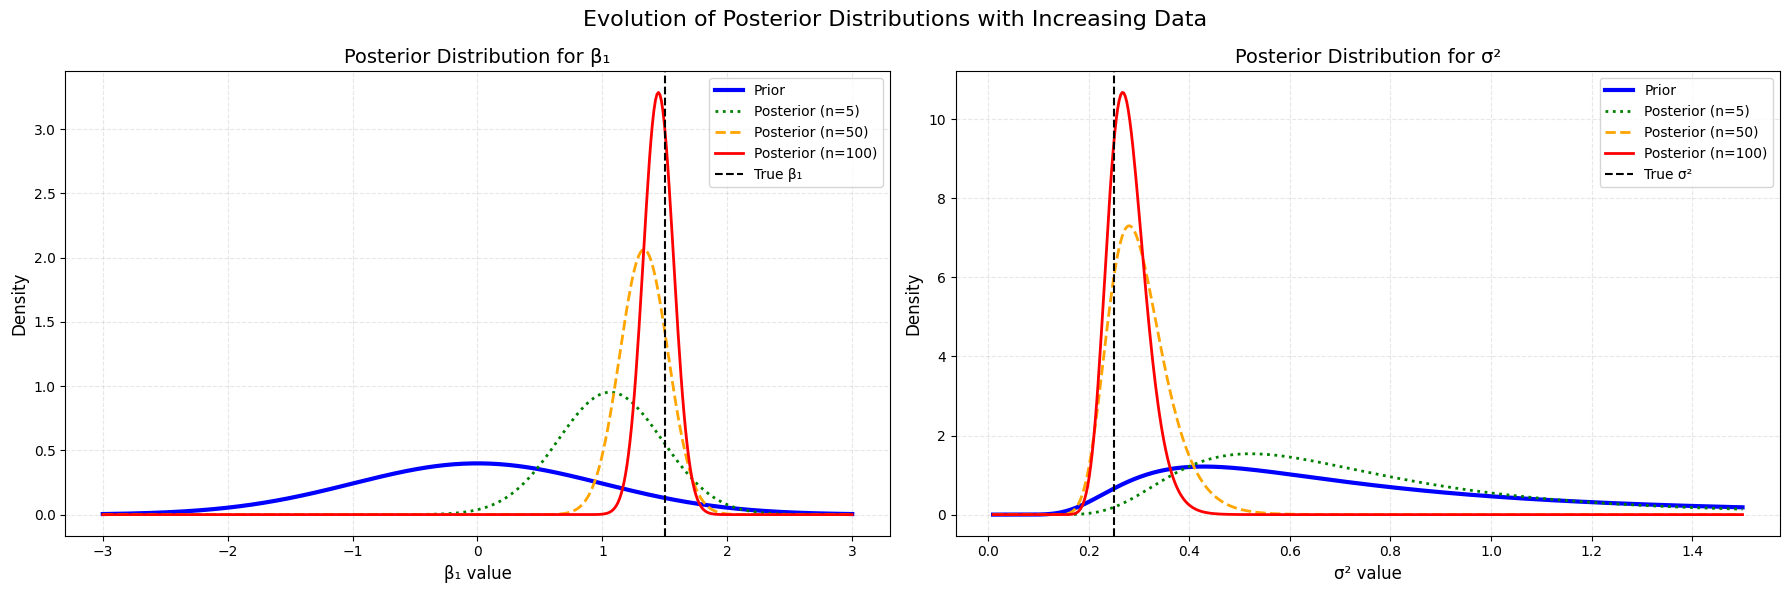

In [13]:
# Observation subsets to plot
observation_subsets = [5, 50, N]
colors = ['green', 'orange', 'red']
line_styles = [':', '--', '-']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# =============================================
# Plot 1: Posterior for β components
# =============================================
beta_grid = np.linspace(-3, 3, 500)

# Plot prior (marginal for first β component)
prior_std = np.sqrt(np.linalg.inv(A_0)[0,0])
ax1.plot(beta_grid, norm.pdf(beta_grid, mu_0[0], prior_std), 
         'b-', linewidth=3, label='Prior')

for n_obs, color, ls in zip(observation_subsets, colors, line_styles):
    X_sub = X[:n_obs]
    y_sub = y[:n_obs]
    
    # Calculate posterior parameters for β
    A_n = X_sub.T @ X_sub + A_0
    mu_n = np.linalg.solve(A_n, X_sub.T @ y_sub + A_0 @ mu_0)
    
    # For visualization, we'll show marginal for β1
    post_var = np.linalg.inv(A_n)[0,0]  # Assuming σ²=1 for visualization
    post_std = np.sqrt(post_var)
    
    ax1.plot(beta_grid, norm.pdf(beta_grid, mu_n[0], post_std),
             color=color, linestyle=ls, linewidth=2,
             label=f'Posterior (n={n_obs})')

ax1.axvline(true_beta[0], color='k', linestyle='--', label='True β₁')
ax1.set_title('Posterior Distribution for β₁', fontsize=14)
ax1.set_xlabel('β₁ value', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.3)

# =============================================
# Plot 2: Posterior for σ²
# =============================================
sigma_sq_grid = np.linspace(0.01, 1.5, 500)

# Plot prior
ax2.plot(sigma_sq_grid, invgamma.pdf(sigma_sq_grid, a=a_0, scale=b_0),
         'b-', linewidth=3, label='Prior')

for n_obs, color, ls in zip(observation_subsets, colors, line_styles):
    X_sub = X[:n_obs]
    y_sub = y[:n_obs]
    
    # Calculate posterior parameters for σ²
    A_n = X_sub.T @ X_sub + A_0
    mu_n = np.linalg.solve(A_n, X_sub.T @ y_sub + A_0 @ mu_0)
    
    a_n = a_0 + n_obs/2
    b_n = b_0 + 0.5*(y_sub.T @ y_sub + mu_0.T @ A_0 @ mu_0 - mu_n.T @ A_n @ mu_n)
    
    ax2.plot(sigma_sq_grid, invgamma.pdf(sigma_sq_grid, a=a_n, scale=b_n),
             color=color, linestyle=ls, linewidth=2,
             label=f'Posterior (n={n_obs})')

ax2.axvline(true_sigma_sq, color='k', linestyle='--', label='True σ²')
ax2.set_title('Posterior Distribution for σ²', fontsize=14)
ax2.set_xlabel('σ² value', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Evolution of Posterior Distributions with Increasing Data', fontsize=16)
plt.tight_layout()
plt.show()

# **Sampling From The Posteriors**

In [ ]:
# Log-posterior function (up to a constant)
def log_posterior(beta, sigma_sq, X, y, mu_0, A_0, a_0, b_0):
    # Log likelihood
    residuals = y - X @ beta
    log_likelihood = -0.5 * N * np.log(sigma_sq) - 0.5 * np.sum(residuals**2) / sigma_sq
    
    # Log prior for beta
    beta_diff = beta - mu_0
    log_prior_beta = -0.5 * beta_diff.T @ A_0 @ beta_diff / sigma_sq
    
    # Log prior for sigma_sq
    log_prior_sigma = -(a_0 + 1) * np.log(sigma_sq) - b_0 / sigma_sq
    
    return log_likelihood + log_prior_beta + log_prior_sigma

In [ ]:
# Metropolis-Hastings sampler
def metropolis_hastings(X, y, initial_beta, initial_sigma_sq, 
                        mu_0, A_0, a_0, b_0, 
                        n_samples=5000, beta_step=0.1, sigma_step=0.1):
    
    # Initialize storage
    beta_samples = np.zeros((n_samples, P))
    sigma_sq_samples = np.zeros(n_samples)
    
    current_beta = initial_beta.copy()
    current_sigma_sq = initial_sigma_sq
    accepted = 0
    
    for i in range(n_samples):
        # Sample beta
        proposed_beta = current_beta + np.random.normal(0, beta_step, P)
        
        # Compute acceptance ratio for beta
        log_alpha = (log_posterior(proposed_beta, current_sigma_sq, X, y, mu_0, A_0, a_0, b_0) - 
                    log_posterior(current_beta, current_sigma_sq, X, y, mu_0, A_0, a_0, b_0))
        
        if np.log(np.random.rand()) < log_alpha:
            current_beta = proposed_beta
            accepted += 1
        
        # Sample sigma_sq (using log-normal proposal)
        proposed_sigma_sq = current_sigma_sq * np.exp(np.random.normal(0, sigma_step))
        
        # Compute acceptance ratio for sigma_sq (with Jacobian term)
        log_alpha = (log_posterior(current_beta, proposed_sigma_sq, X, y, mu_0, A_0, a_0, b_0) - 
                    log_posterior(current_beta, current_sigma_sq, X, y, mu_0, A_0, a_0, b_0) + 
                    np.log(proposed_sigma_sq) - np.log(current_sigma_sq))  # Jacobian adjustment
        
        if np.log(np.random.rand()) < log_alpha:
            current_sigma_sq = proposed_sigma_sq
            accepted += 1
        
        # Store samples
        beta_samples[i] = current_beta
        sigma_sq_samples[i] = current_sigma_sq
    
    acceptance_rate = accepted / (2 * n_samples)  # Two updates per iteration
    print(f"Overall acceptance rate: {acceptance_rate:.2f}")
    
    return beta_samples, sigma_sq_samples

In [ ]:
# Run MCMC
initial_beta = np.zeros(P)
initial_sigma_sq = 1.0
beta_samples, sigma_sq_samples = metropolis_hastings(
    X, y, initial_beta, initial_sigma_sq, 
    mu_0, A_0, a_0, b_0,
    n_samples=10000, beta_step=0.1, sigma_step=0.1
)

Overall acceptance rate: 0.49


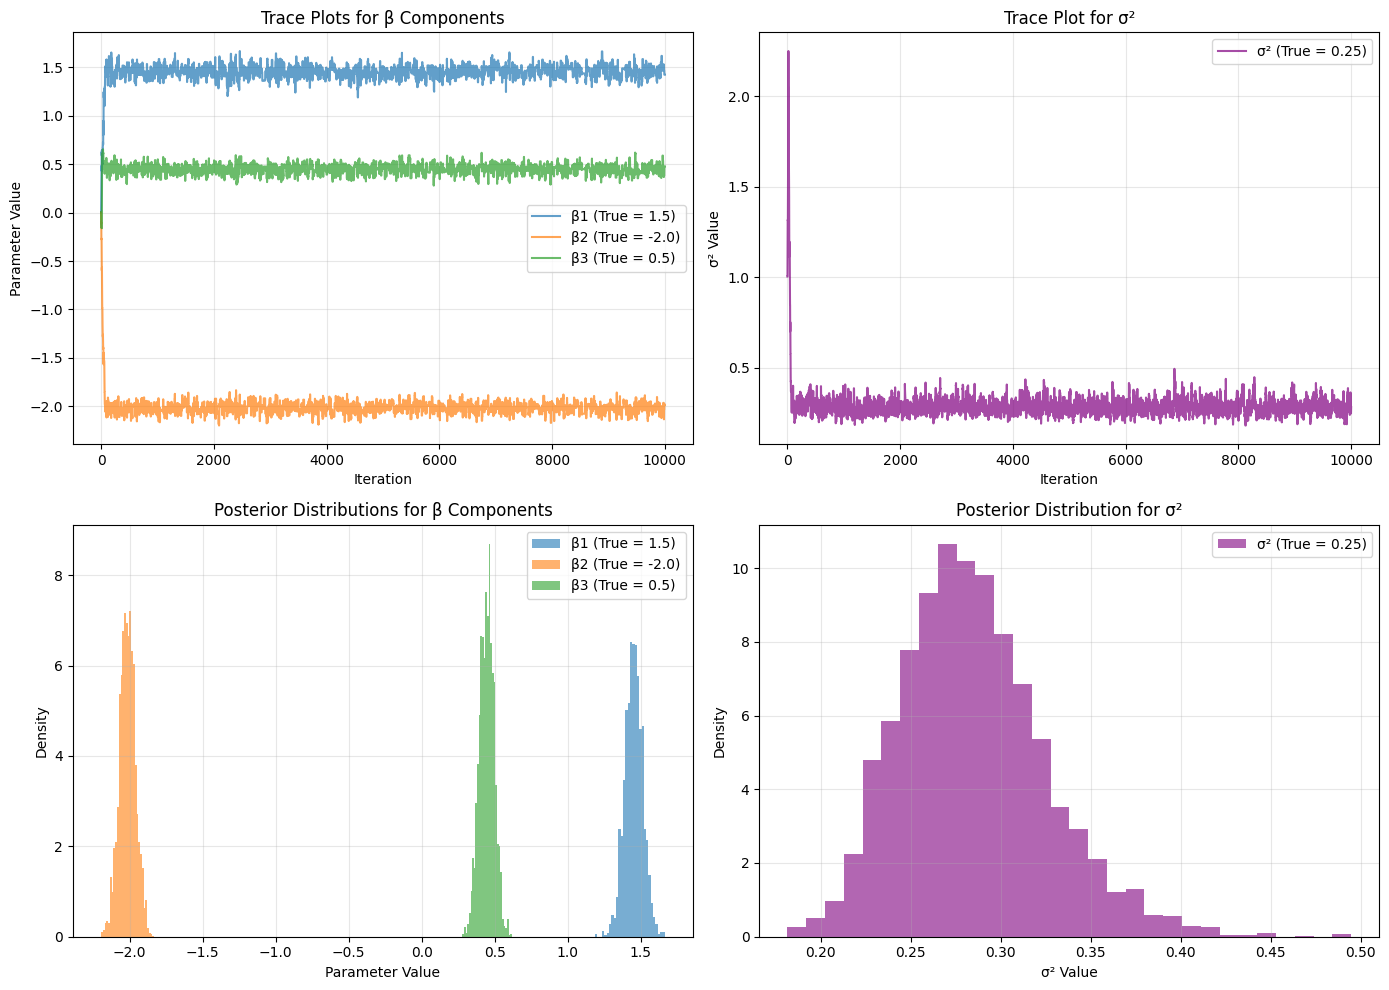

In [ ]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trace plots for beta components
for p in range(P):
    axes[0,0].plot(beta_samples[:, p], alpha=0.7, 
                   label=f'β{p+1} (True = {true_beta[p]:.1f})')
axes[0,0].set_title('Trace Plots for β Components')
axes[0,0].set_xlabel('Iteration')
axes[0,0].set_ylabel('Parameter Value')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Trace plot for sigma²
axes[0,1].plot(sigma_sq_samples, alpha=0.7, color='purple',
               label=f'σ² (True = {true_sigma**2:.2f})')
axes[0,1].set_title('Trace Plot for σ²')
axes[0,1].set_xlabel('Iteration')
axes[0,1].set_ylabel('σ² Value')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Histograms for beta components
for p in range(P):
    axes[1,0].hist(beta_samples[2000:, p], bins=30, density=True, alpha=0.6,
                   label=f'β{p+1} (True = {true_beta[p]:.1f})')
axes[1,0].set_title('Posterior Distributions for β Components')
axes[1,0].set_xlabel('Parameter Value')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Histogram for sigma²
axes[1,1].hist(sigma_sq_samples[2000:], bins=30, density=True, alpha=0.6, color='purple',
               label=f'σ² (True = {true_sigma**2:.2f})')
axes[1,1].set_title('Posterior Distribution for σ²')
axes[1,1].set_xlabel('σ² Value')
axes[1,1].set_ylabel('Density')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()